In [3]:
import os
import glob
import json
from numpy import genfromtxt
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [97]:
def plot_curves(files, title, labeler, xlim=15000, mtn=True):
    alldata = []
    
    plt.figure(figsize=(15, 10))
    plt.title(title)
    
    for f in files:
        job_id = int(f.split("/")[1])
        jobdir = "/".join(f.split("/")[:-1]) + "/"
    
        with open(jobdir + "command.txt", "r") as f:
            com = f.readlines()
            
        args = json.load(open(jobdir + "args.txt", "r"))
        
        label = labeler(job_id, com, args)
        
        if label is None:
            continue
        
        data = genfromtxt(jobdir + 'scores.txt', delimiter='\t', skip_header=1)
        if len(data.shape) < 2:
            continue
        steps = data[:, 0]
        means = data[:, 3]

        #plt.plot(data[:, 0], data[:, 3])
        alldata.append([label, job_id, steps, means])
        
    types = list(set([d[0] for d in alldata]))
    types.sort()
    
    for t in types:
        allmeans = []
        
        for label, job, steps, means in alldata:
            if label == t:
                allmeans.append(means)
                s = steps
        
        minlen = min([len(m) for m in allmeans])
        allmeans = [m[:minlen] for m in allmeans]
        
        allmeans = np.array(allmeans)
        
        #allmeans = allmeans[np.argsort(allmeans[:, -1])[-5:]]
        
        means = np.mean(allmeans, axis=0)
        stds = np.std(allmeans, axis=0)
        
        t += " {" + str(len(allmeans)) + "}"
        
        p = plt.plot(s[:minlen], means, label=t)
        
        for mean in allmeans:
            plt.plot(s[:minlen], mean, color=p[0].get_color() + "20")
        #plt.fill_between(s[:minlen], means-stds, means+stds, color=p[0].get_color() + "20")
    
    if mtn:
        plt.plot([0, 1000000], [-110, -110], lw=2, ls="--")
    plt.xlim((0, xlim))
    plt.xlabel("steps")
    plt.legend()
    plt.show()

In [63]:
def labeler_fn(dqn, repeat, start_job, end_job=None):
    def labeler(job, com, args):
        
        
        if job < start_job:#130841:#127346:#127286:#126608:#125890:
            return None
        if end_job is not None and job > end_job:
            return None

        com = com[0]
        label = ""

        if 'train_dqn_gym' in com:
            label += "DQN"
            if not dqn:
                return None
        elif 'train_categorical' in com:
            label += "C51"
            if dqn:
                return None
            
        if 'reward_scale_factor' not in args:
            return None
            
        if 'lr' in args:
            label += " lr=" + str(args["lr"])
        
        if 'reward_scale_factor' in args and args['reward_scale_factor'] == 1:
            label += ' r=' + str(args['reward_scale_factor'])
        else:
            return None
        
        if 'rbuf' in args:
            label += ' rbuf=' + str(args['rbuf'])
            
        if args['target_update_method'] == 'soft':
            label += ' soft'
        
        #label += ' ti=' + str(args['target_update_interval'])
            
        #label += " lr=" + str(args['lr'])
        #label += " rs=" + str(args['reward_scale_factor'])
        
        if args['action_repeat'] != repeat:
            return None

        if args['noisy_net_sigma'] and args['noise_constant'] > 0:
            label += " constant noise (sigma = " + str(args['noise_constant']) + ")"
            return None
        elif args['noisy_net_sigma']:
            label += " noisy nets (sigma0 = " + str(args['noisy_net_sigma']) + ")"
        else:
            #label += " exp-init=" + str(args['final_exploration_steps'])
            pass
        
        if "lr=0.001 r=1.0" in label:
            print(job, com)

        return label
    
    return labeler

131437 examples/gym/train_dqn_gym.py --env MountainCar-v0 --steps 400000 --action-repeat 1 --gamma 0.99 --n-hidden-layers 1 --n-hidden-channels 16 --final-exploration-steps 100000 --seed 4 --reward-scale-factor 1 --rbuf 2000
131415 examples/gym/train_dqn_gym.py --env MountainCar-v0 --steps 400000 --action-repeat 1 --gamma 0.99 --n-hidden-layers 1 --n-hidden-channels 16 --final-exploration-steps 100000 --seed 4 --reward-scale-factor 1 --target-update-method soft --soft-update-tau 0.125
131436 examples/gym/train_dqn_gym.py --env MountainCar-v0 --steps 400000 --action-repeat 1 --gamma 0.99 --n-hidden-layers 1 --n-hidden-channels 16 --final-exploration-steps 100000 --seed 3 --reward-scale-factor 1 --rbuf 2000
130850 examples/gym/train_dqn_gym.py --env MountainCar-v0 --steps 400000 --action-repeat 1 --gamma 0.99 --n-hidden-layers 2 --n-hidden-channels 32 --lr 0.001 --final-exploration-steps 100000 --seed 10 --reward-scale-factor 1 --lr 0.001 --target-update-interval 100
130845 examples/gym/

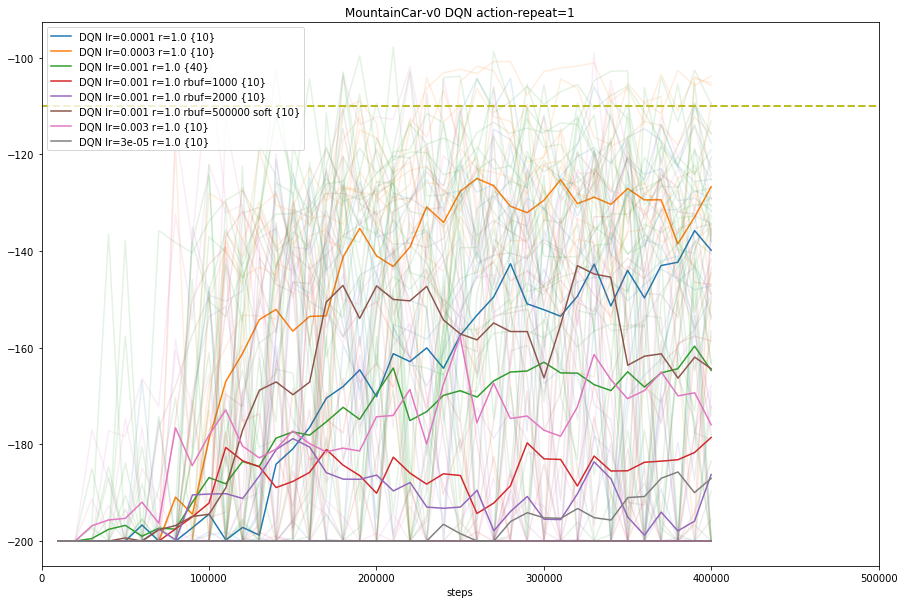

In [64]:
plot_curves(glob.glob("results/*/*/scores.txt"), "MountainCar-v0 DQN action-repeat=1",
            labeler_fn(True, 1, 130000, 131443), 500000)

/home/sean/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: genfromtxt: Empty input file: "results/133617/20180613T172045.471220/scores.txt"
/home/sean/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: genfromtxt: Empty input file: "results/133615/20180613T171204.887210/scores.txt"
/home/sean/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: genfromtxt: Empty input file: "results/133619/20180613T172541.312499/scores.txt"


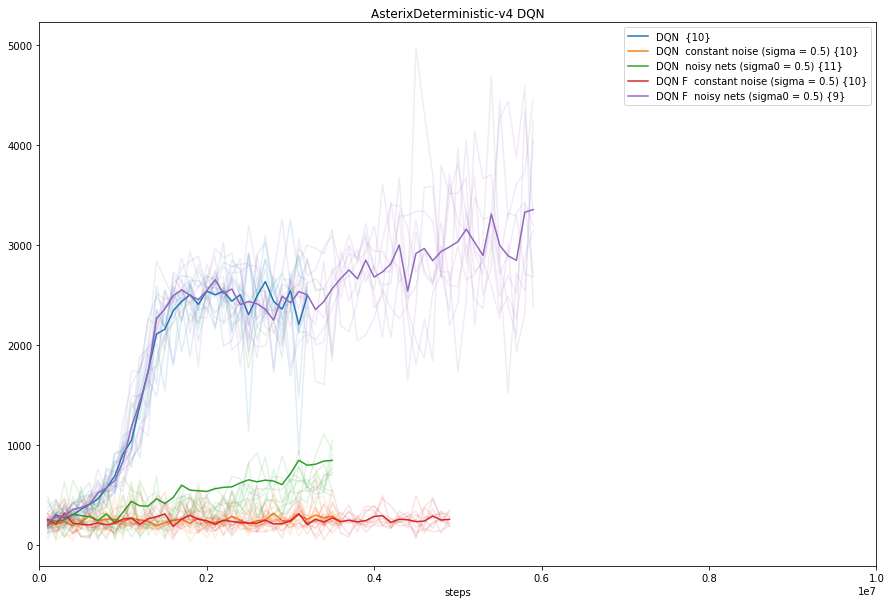

In [101]:
def labeler_fn2(dqn, repeat, start_job, end_job=None):
    def labeler(job, com, args):
        if job < start_job:#130841:#127346:#127286:#126608:#125890:
            return None
        if end_job is not None and job > end_job:
            return None

        com = com[0]
        label = "DQN "
        
        if job > 133595:
            label += "F "
        
        if args['noisy_net_sigma'] and args['noise_constant'] > 0:
            label += " constant noise (sigma = " + str(args['noise_constant']) + ")"
        elif args['noisy_net_sigma'] > 0:
            label += " noisy nets (sigma0 = " + str(args['noisy_net_sigma']) + ")"
        
        return label

    return labeler

start = 133126#131653
plot_curves(glob.glob("results/*/*/scores.txt"), "AsterixDeterministic-v4 DQN",
            labeler_fn2(True, 1, start), 10000000, mtn=False)

In [77]:
plot_curves(glob.glob("results/*/*/scores.txt"), "MountainCar-v0 DQN action-repeat=4", labeler_fn(True, 4), 500000)

TypeError: labeler_fn() missing 1 required positional argument: 'start_job'

No handles with labels found to put in legend.


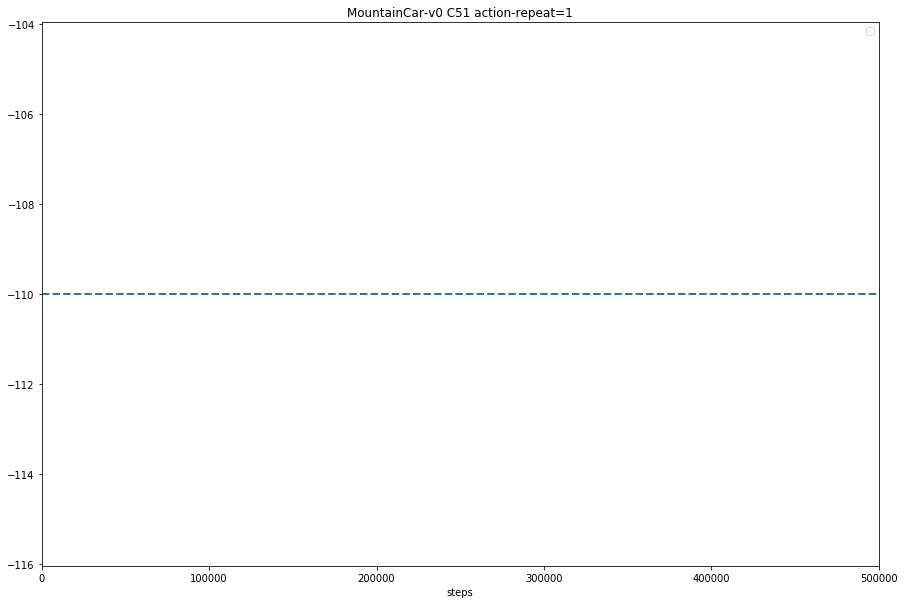

In [144]:
plot_curves(glob.glob("results/*/*/scores.txt"), "MountainCar-v0 C51 action-repeat=1", labeler_fn(False, 1), 500000)

No handles with labels found to put in legend.


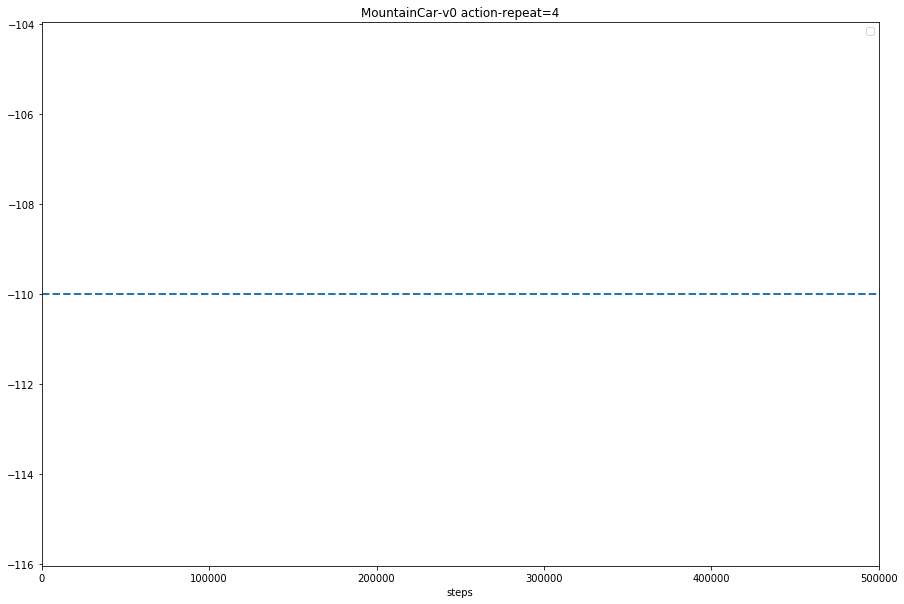

In [145]:
plot_curves(glob.glob("results/*/*/scores.txt"), "MountainCar-v0 action-repeat=4", labeler_fn(False, 4), 500000)